# Auto-tune a pseudo-Voigt peak with BlueSky

A common peak shape function in X-ray diffraction is the pseudo-Voigt profile.
It combines a Gaussian peak profile function, G(x), with a Lorentzian, L(x), as controlled 
by a mixing factor eta (0 <= eta <= 1) which represents the fraction of the total peak profile
function that is Lorentzian:

$$ P(x) = \eta \  L(x) + (1-\eta) \  G(x) $$



## Standard startup configuration

This code would normally go in a script automatically run at startup. The user would not have to worry about this.

In [1]:
%matplotlib notebook

# Make plots live-update while scans run.
from bluesky.utils import install_nb_kicker
install_nb_kicker()

from bluesky import RunEngine
from bluesky.plans import scan, relative_scan, list_scan, stage_decorator, run_decorator, Msg, mv, trigger_and_read
from bluesky.callbacks import LiveTable, LivePlot
from bluesky.examples import motor, Reader

# Import matplotlib and put it in interactive mode.
from ophyd import setup_ophyd
setup_ophyd()

import matplotlib.pyplot as plt
plt.ion()

# Make plots update live while scans run.
from bluesky.utils import install_nb_kicker
install_nb_kicker()

try:
    import seaborn
except ImportError:
    pass

import numpy as np

RE = RunEngine({})

## unreleased functions in the BlueSky pipeline

In [2]:
# from bluesky.plans (not released for production as of 2017-10-31)
def tune_centroid(
        detectors, signal, motor, 
        start, stop, min_step, 
        num=10, 
        step_factor=2,
        snake=False,
        *, md=None):
    """
    plan: tune a motor to the centroid of signal(motor)
    
    Initially, traverse the range from start to stop with
    the number of points specified.  Repeat with progressively
    smaller step size until the minimum step size is reached.
    Rescans will be centered on the signal centroid
    (for $I(x)$, centroid$= \sum{I}/\sum{x*I}$)
    with a scan range of 2*step_factor*step of current scan.
    
    Set `snake=True` if your positions are reproducible
    moving from either direction.  This will not necessarily
    decrease the number of traversals required to reach convergence.
    Snake motion reduces the total time spent on motion
    to reset the positioner.  For some positioners, such as 
    those with hysteresis, snake scanning may not be appropriate.  
    For such positioners, always approach the positions from the 
    same direction.
    
    Note:  Ideally the signal has only one peak in the range to 
    be scanned.  It is assumed the signal is not polymodal 
    between `start` and `stop`. 

    Parameters
    ----------
    detectors : Signal
        list of 'readable' objects
    signal : string
        detector field whose output is to maximize
    motor : object
        any 'setable' object (motor, temp controller, etc.)
    start : float
        start of range
    stop : float
        end of range, note: start < stop
    min_step : float
        smallest step size to use.
    num : int, optional
        number of points with each traversal, default = 10
    step_factor : float, optional
        used in calculating range when 
        maximum is found, note: step_factor > 0, default = 2
    snake : bool, optional
        if False (default), always scan from start to stop
    md : dict, optional
        metadata

    Example
    -------
    motor = Mover('motor', {'motor': lambda x: x}, {'x': 0})
    det = SynGauss('det', motor, 'motor', center=-1.3, Imax=1e5, sigma=0.05)
    RE(tune_centroid([det], "det", motor, -1.5, -0.5, 0.01, 10))
    """
    if min_step <= 0:
        raise ValueError("min_step must be positive")
    if step_factor <= 0:
        raise ValueError("step_factor must be positive")
    if (num - 2) <= 2*step_factor:
        raise ValueError(
            "Increase num and/or decrease step_factor"
            " or tune_centroid will never converge to a solution"
        )
    try:
        motor_name, = motor.hints['fields']
    except (AttributeError, ValueError):
        motor_name = motor.name
    _md = {'detectors': [det.name for det in detectors],
           'motors': [motor.name],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motor': repr(motor),
                         'start': start,
                         'stop': stop,
                         'num': num,
                         'min_step': min_step,},
           'plan_name': 'tune_centroid',
           'hints': {},
          }
    _md.update(md or {})
    try:
        dimensions = [(motor.hints['fields'], 'primary')]
    except (AttributeError, KeyError):
        pass
    else:
        _md['hints'].setdefault('dimensions', dimensions)

    low_limit = min(start, stop)
    high_limit = max(start, stop)

    @stage_decorator(list(detectors) + [motor])
    @run_decorator(md=_md)
    def _tune_core(start, stop, num, signal):
        next_pos = start
        step = (stop - start) / (num - 1)
        peak_position = None
        cur_I = None
        cur_det = {}
        sum_I = 0       # for peak centroid calculation, I(x)
        sum_xI = 0
        
        while abs(step) >= min_step:
            yield Msg('checkpoint')
            yield from mv(motor, next_pos)
            ret = (yield from trigger_and_read(detectors + [motor]))
            cur_I = ret[signal]['value']
            sum_I += cur_I
            position = ret[motor_name]['value']
            sum_xI += position * cur_I

            if (stop - start) < abs(stop - start):
                in_range = start >= next_pos >= stop  # negative motion
            else:
                in_range = start <= next_pos <= stop  # positive motion
            
            if in_range:
                next_pos += step
            else:
                if sum_I == 0:
                    return
                peak_position = sum_xI / sum_I  # centroid
                # improvement: report current peak_position somehow
                start = np.clip(peak_position - step_factor*step, low_limit, high_limit)
                stop = np.clip(peak_position + step_factor*step, low_limit, high_limit)
                if snake:
                    start, stop = stop, start
                step = (stop - start) / (num - 1)
                next_pos = start

        # finally, move to peak position
        if peak_position is not None:
            # improvement: report final peak_position
            yield from mv(motor, peak_position)

    return (yield from _tune_core(start, stop, num, signal))


In [3]:
# 2017-10-31: pull request
class SynPseudoVoigt(Reader):
    """
    Evaluate a point on a pseudo-Voigt based on the value of a motor.
    
    :see: https://en.wikipedia.org/wiki/Voigt_profile

    Parameters
    ----------
    name : str
        name of detector signal
    motor : `Mover`
        The independent coordinate
    motor_field : str
        name of `Mover` field
    center : float, optional
        location of maximum value, default=0
    eta : float, optional
        0 <= eta < 1.0: Lorentzian fraction, default=0.5
    scale : float, optional
        scale >= 1 : scale factor, default=1
    sigma : float, optional
        sigma > 0 : width, default=1
    bkg : float, optional
        bkg >= 0 : constant background, default=0
    noise : {'poisson', 'uniform', None}
        Add noise to the result.
    noise_multiplier : float
        Only relevant for 'uniform' noise. Multiply the random amount of
        noise by 'noise_multiplier'

    Example
    -------
    motor = Mover('motor', {'motor': lambda x: x}, {'x': 0})
    det = SynPseudoVoigt('det', motor, 'motor', 
        center=0, eta=0.5, scale=1, sigma=1, bkg=0)
    """

    def __init__(self, name, motor, motor_field, center=0, 
                eta=0.5, scale=1, sigma=1, bkg=0, 
                noise=None, noise_multiplier=1,
                **kwargs):
        if eta < 0.0 or eta > 1.0:
            raise ValueError("eta={} must be between 0 and 1".format(eta))
        if scale < 1.0:
            raise ValueError("scale must be >= 1")
        if sigma <= 0.0:
            raise ValueError("sigma must be > 0")
        if bkg < 0.0:
            raise ValueError("bkg must be >= 0")
        
        # remember these terms for later access by user
        self.name = name
        self.motor = motor
        self.center = center
        self.eta = eta
        self.scale = scale
        self.sigma = sigma
        self.bkg = bkg
        self.noise = noise
        self.noise_multiplier = noise_multiplier

        def f_lorentzian(x, gamma):
            # same as: gamma / np.pi / (x**2 + gamma**2)
            return 1 / np.pi / gamma / (1 + (x/gamma)**2)

        def f_gaussian(x, sigma):
            numerator = np.exp(-0.5 * (x / sigma) ** 2)
            denominator = sigma * np.sqrt(2 * np.pi)
            return numerator / denominator

        def pvoigt():
            m = motor.read()[motor_field]['value']
            g_max = f_gaussian(0, sigma)    # peak normalization
            l_max = f_lorentzian(0, sigma)
            v = bkg
            if eta > 0:
                v += eta * f_lorentzian(m - center, sigma) / l_max
            if eta < 1:
                v += (1-eta) * f_gaussian(m - center, sigma) / g_max
            v *= scale
            if noise == 'poisson':
                v = int(np.random.poisson(np.round(v), 1))
            elif noise == 'uniform':
                v += np.random.uniform(-1, 1) * noise_multiplier
            return v

        super().__init__(name, {name: pvoigt}, **kwargs)


# First simulation: a pseudo-Voigt profile, 0.1% Lorentzian (99.9% Gaussian)

In [4]:
det = Reader('det', {'intensity': lambda: 2 * motor.read()['value']})

synthetic_pseudovoigt = SynPseudoVoigt(
    'synthetic_pseudovoigt', motor, 'motor', 
    center=1, 
    eta=0.001, 
    sigma=0.01, 
    scale=1e5)

table = LiveTable(['synthetic_pseudovoigt', 'motor_setpoint', 'motor'])


<IPython.core.display.Javascript object>


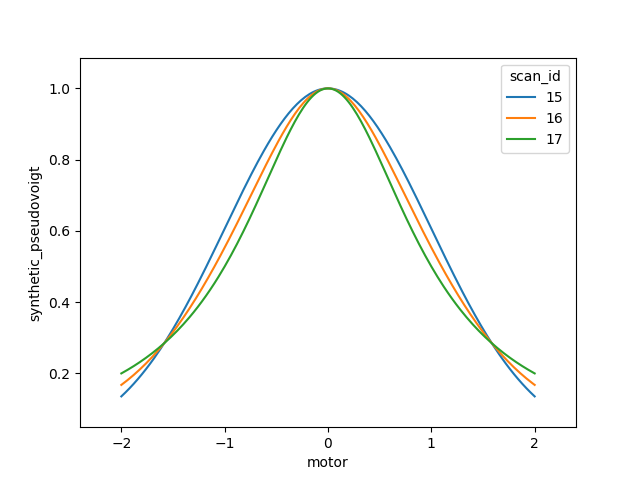

('80ec015f-918b-4699-9b27-1457bd9100cc',
 'da2eba05-3524-4987-9ea5-1b10c7627f51',
 'e4b9edb4-8005-4159-8c90-d40352df66cf')

In [11]:
def central_region():
    synthetic_pseudovoigt = SynPseudoVoigt(
        'synthetic_pseudovoigt', motor, 'motor', eta=0.001)
    yield from scan([synthetic_pseudovoigt], motor, -2, 2, 201)
    synthetic_pseudovoigt = SynPseudoVoigt(
        'synthetic_pseudovoigt', motor, 'motor', eta=0.5)
    yield from scan([synthetic_pseudovoigt], motor, -2, 2, 201)
    synthetic_pseudovoigt = SynPseudoVoigt(
        'synthetic_pseudovoigt', motor, 'motor', eta=0.999)
    yield from scan([synthetic_pseudovoigt], motor, -2, 2, 201)

    
RE(central_region(), LivePlot('synthetic_pseudovoigt', 'motor'))

<IPython.core.display.Javascript object>


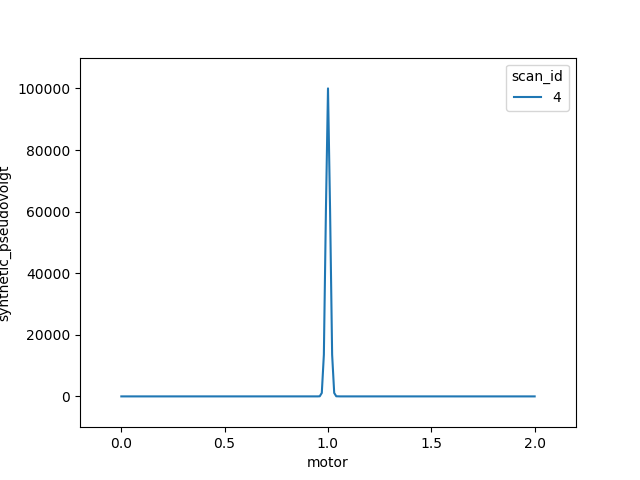

('a16149dd-c423-4dd9-bfa7-ed7e0190bcf1',)

In [6]:
synthetic_pseudovoigt = SynPseudoVoigt(
    'synthetic_pseudovoigt', motor, 'motor', 
    center=1, 
    eta=0.001, 
    sigma=0.01, 
    scale=1e5)

RE(scan([synthetic_pseudovoigt], motor, 0, 2, 201), LivePlot('synthetic_pseudovoigt', 'motor'), peak="eta=0.001")

# simulation: a pseudo-Voigt profile, 99.9% Lorentzian (0.1% Gaussian)

<IPython.core.display.Javascript object>


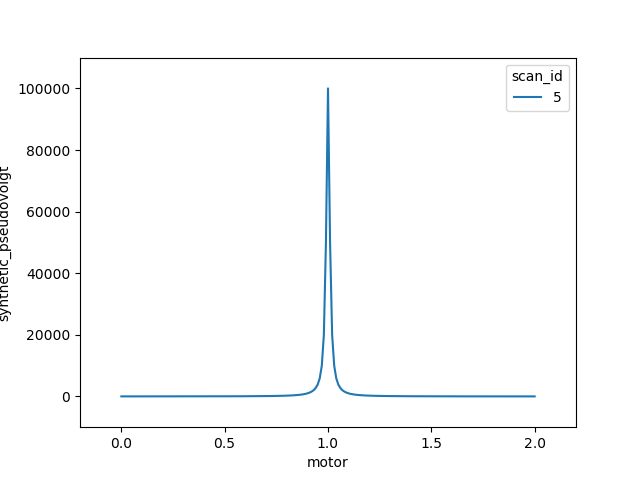

('e63ee542-c64b-45ea-a277-08e1e2de78e2',)

In [7]:
synthetic_pseudovoigt = SynPseudoVoigt(
    'synthetic_pseudovoigt', motor, 'motor', 
    center=1, 
    eta=0.999, 
    sigma=0.01, 
    scale=1e5)

#RE(scan([synthetic_pseudovoigt], motor, 0, 2, 201), subscriptions, peak="eta=0.9")
RE(scan([synthetic_pseudovoigt], motor, 0, 2, 201), LivePlot('synthetic_pseudovoigt', 'motor'), peak="eta=0.999")

# simulation: a pseudo-Voigt profile, 50% Lorentzian (50% Gaussian)

<IPython.core.display.Javascript object>


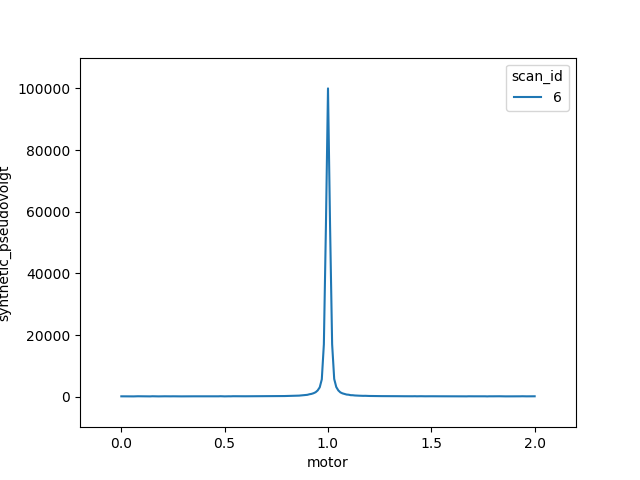

('f24ddf91-92ec-4bd3-a6aa-87ebb5cd0ab3',)

In [8]:
synthetic_pseudovoigt = SynPseudoVoigt(
    'synthetic_pseudovoigt', motor, 'motor', 
    center=1, 
    eta=0.5, 
    sigma=0.01, 
    scale=1e5,
    noise="poisson",
    bkg=1e-3)

RE(scan([synthetic_pseudovoigt], motor, 0, 2, 201), LivePlot('synthetic_pseudovoigt', 'motor'), peak="eta=0.9")

# demonstrate auto-tune to the centroid

<IPython.core.display.Javascript object>


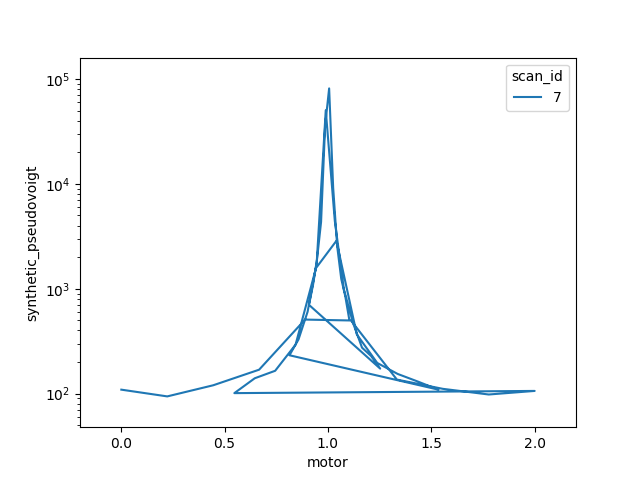

+-----------+------------+-----------------------+----------------+------------+
|   seq_num |       time | synthetic_pseudovoigt | motor_setpoint |      motor |
+-----------+------------+-----------------------+----------------+------------+
|         1 | 14:22:16.1 |                109.00 |           0.00 |       0.00 |
|         2 | 14:22:16.1 |                 94.00 |           0.22 |       0.22 |
|         3 | 14:22:16.2 |                120.00 |           0.44 |       0.44 |
|         4 | 14:22:16.2 |                169.00 |           0.67 |       0.67 |
|         5 | 14:22:16.2 |                508.00 |           0.89 |       0.89 |
|         6 | 14:22:16.3 |                498.00 |           1.11 |       1.11 |
|         7 | 14:22:16.3 |                136.00 |           1.33 |       1.33 |
|         8 | 14:22:16.3 |                111.00 |           1.56 |       1.56 |
|         9 | 14:22:16.3 |                 98.00 |           1.78 |       1.78 |
|        10 | 14:22:16.4 |  

In [9]:
def tune_fraction_calc(motor, det):
    return (motor.read()[motor.name]["value"] - det.center) / det.sigma

RE(
    tune_centroid(
        [synthetic_pseudovoigt], "synthetic_pseudovoigt", motor, 
        0, 2, 0.01, 10
    ),
    [table,
    LivePlot('synthetic_pseudovoigt', 'motor')
    ]
)
tune_fraction = tune_fraction_calc(motor, synthetic_pseudovoigt)
print("tuned to {} fraction of peak sigma".format(tune_fraction))


# Fit a sequence pf peaks

Fit a sequence of peaks with different centers and widths

<IPython.core.display.Javascript object>


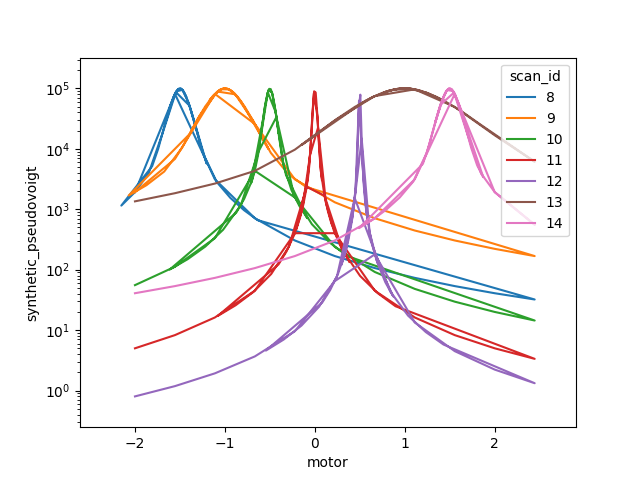

center=-1.5, sigma=0.1
tuned to -0.025285094929021756 fraction of peak sigma
center=-1.0, sigma=0.2
tuned to 0.03854162646461545 fraction of peak sigma
center=-0.5, sigma=0.05
tuned to 0.04271967326808457 fraction of peak sigma
center=0, sigma=0.02
tuned to 0.016015133877997648 fraction of peak sigma
center=0.5, sigma=0.01
tuned to -0.06866233777568787 fraction of peak sigma
center=1.0, sigma=0.5
tuned to -0.05443567658928683 fraction of peak sigma
center=1.5, sigma=0.1
tuned to -0.005448446469975554 fraction of peak sigma


('537d45cb-02d7-43da-81a5-106bf673deff',
 '30d36933-d0aa-4c0b-94d0-e4dd656c3e05',
 'a90ee177-6c84-4bc8-9207-e5d79c577bca',
 '93890d3d-eb08-4c6d-be68-caa2908148fb',
 'e725579d-0582-4370-a251-14c8efb2f1ec',
 '340a21ac-81b1-4ddf-baff-cc438b4af108',
 'b2bb8aa5-e11f-475e-9887-efa5afc67374')

In [10]:
def peaks_sequence():
    sequence = (
        (-1.5, 0.1),
        (-1.0, 0.2),
        (-0.5, 0.05),
        (0, .02),
        (0.5, 0.01),
        (1.0, 0.5),
        (1.5, 0.1)
    )
    for center, sigma in sequence:
        print("center={}, sigma={}".format(center, sigma))
        synthetic_pseudovoigt = SynPseudoVoigt(
            'synthetic_pseudovoigt', motor, 'motor', 
            center=center, 
            eta=0.5, 
            sigma=sigma, 
            scale=1e5)
        yield from tune_centroid(
                [synthetic_pseudovoigt], "synthetic_pseudovoigt", motor, 
                -2, 2, 0.01, 10,
                snake=True
            )
        tune_fraction = tune_fraction_calc(motor, synthetic_pseudovoigt)
        print("tuned to {} fraction of peak sigma".format(tune_fraction))

RE(
    peaks_sequence(),
    LivePlot('synthetic_pseudovoigt', 'motor')
)